# Define the problem

**Process Management Problem**

In the process management problem, we are given a set of tasks represented by processes $p$. Each process $p_i$ has an associated value $v_i$​ (indicating its importance) and a duration $d_i$​ (representing the time required to execute the task). Additionally, there exists a maximum allowed duration $d_{max}$​ within which we must execute these tasks.


Our objective is to select a subset $S$ of processes from $p$ such that their total duration does not exceed $d_{max}$​, while maximizing the overall value of the executed processes. In other words, we aim to find the set S that maximizes the expression:

$$\sum_{i\in S} v_i$$

subject to the constraint:

$$\sum_{i\in S} d_i \leq d_{max}$$

## Define problem instance

In [1]:
import random 


random.seed(13)

# Define the number of items
n_items = 6

# Define ranges
duration_range = [1, 7]
values_range = [5, 15]
max_duration_percentage = 0.7

# Fill the weights and values 
duration = [random.randint(duration_range[0], duration_range[1]) for _ in range(n_items)]
values  = [random.randint(values_range[0], values_range[1]) for _ in range(n_items)]

# Compute the maximum allowed weight
max_duration = int(max_duration_percentage * sum(duration))


# Print the instance
print("-" * 20)
print("Instance Details:")
print("-" * 20)
print(f"Duration                 : {duration}")
print(f"Values                   : {values}")
print(f"Total duration           : {sum(duration)}")
print(f"Maximum allowed duration : {max_duration}")

--------------------
Instance Details:
--------------------
Duration                 : [3, 3, 6, 6, 7, 7]
Values                   : [7, 15, 8, 15, 7, 8]
Total duration           : 32
Maximum allowed duration : 22


Reference Solution (Selected Processes are **Bolded**):

Duration: [3, **3**, **6**, **6**, 7, **7**]

Values: [7, **15**, **8**, **15**, 7, **8**]

Total selected Duration: 22

Total selected values: 46

# Hackathon Tasks 


## Problem 1

### Build the cost hamiltonians for the Process Management problem:

The **process management problem** is analogous to the **knapsack problem with integer weights** contained in the 21 Karp's NP problems. A good explanation for how to formulate this problem to be run in a Quantum Adiabatic Optimization process can be found in the work done by A. Lucas, [Ising formulation of many NP problems](https://arxiv.org/abs/1302.5843), in 2014. 

To clarify, we have a list of $p$ processes, labeled by $x_i$, with duration, $d_i$ and value, $c_i$. We also have a maximum duration, $d_{max}$, that limits the amount of selected processes.

In this case each bit (process) $x_i$ in the bit-string is defined by the encoding for each of the bits:

$$ 
x_i = \begin{cases} 
            1 & \text{process asigned to be computed} \\
            0 & \text{process not asigned to be computed}
         \end{cases}
$$

We can define a mathematical expression $D$ to evaluate the duration of a given bit-string,

$$D = \sum_{i=1}^{p} d_i x_i$$

and a mathematical expression $C$ to evaluate the value of a given bit-string,

$$C = \sum_{i=1}^{p} c_i x_i$$

In this NP-hard process management problem we are asked to maximize the value of the selected processes, $C$, given that the duration of the selected processes, $D$, does not exceed the maximum duration allowed, $D \leq d_{max}$.

Hence, one of the possible cost functions can take the form:

$$\mathcal{C} = \left( \sum_{i=1}^{p} c_i x_i \right) - \left( \sum_{i=1}^{p} d_i x_i + \sum_{i=1}^{b} b_i y_{i} - d_{max} \right)^2$$

where the first term accounts for the maximization of the string importance, $C$, whereas the second term ensures that the duration constraint is fulfilled. This second term is a penalty term that will be zero if the duration constraint is satisfied, and will penalize the cost function if the duration constraint is violated. The $y_i$ are Lagrange multipliers that are introduced to enforce the constraint. The $b_i$ are the penalty weights that determine how harsh the penalty is, and $b$ is the length of these coefficients.

At this point, we can define the cost Hamiltonian to be minimazed by mapping the binary varibles $x_i, y_i \xrightarrow{} \hat{z}_i=\frac{\mathcal{I}-\mathcal{Z}}{2}$, where $\mathcal{I}$ is the identity matrix and $\mathcal{Z}$ the Pauli Z matrix. So that the cost Hamiltonian can be written as:

$$\mathcal{H}_C = -\left( \sum_{i=1}^{p} c_i \hat{z}_i \right) + \left( \sum_{i=1}^{p} d_i \hat{z}_i + \sum_{i=1}^{b} b_i \hat{z}_{i+p} - d_{max} \right)^2$$

therefore one can find the ground state (GS) by applying it on a set of $p+b$ qubits, where the GS will be the solution to the problem. Note that the first term is a minimization term, while the second term is a penalty term that will be zero if the duration constraint is satisfied, and will penalize the cost Hamiltonian if the duration constraint is violated, so this state can not be a GS (solution).

In [2]:
from qibo.symbols import Z, X
from qibo.hamiltonians import SymbolicHamiltonian
import numpy as np

max_pow_b = np.ceil(np.log2(max(duration)))
b = [2**i for i in range(int(max_pow_b) + 1)]    # binary values coefficients

def build_cost_hamiltonian(values: list[int], duration: list[int], max_duration: int) -> SymbolicHamiltonian:
    """This function should be filled to build the problem cost hamiltonian.

    Args:
        values (list[int]): the list of values.
        duration (list[int]): the list of durations. 
        max_duration (int): the maximum value of the allowed duration.
        
    """
    cost_hamiltonian= (-0.5*sum(values[i]*(1-Z(i)) for i in range(len(values))) + 
                       (0.5*sum(duration[i]*(1-Z(i)) for i in range(len(values))) + 
                        0.5*sum(b[i]*(1-Z(i + n_items)) for i in range(len(b))) - max_duration)**2)
    return SymbolicHamiltonian(cost_hamiltonian)

build_cost_hamiltonian(values, duration, max_duration)

[Qibo 0.2.7|INFO|2024-05-05 11:17:02]: Using numpy backend on /CPU:0


### Compute the number fo qubits required to execute the cost hamiltonian

In [3]:
# Compute the number of qubits which is the number of values, p, and the number of Lagrange multipliers, b.

nqubits = len(values) + len(b)
print(nqubits)

10


### Diagonalize the cost hamiltonian and examen its eigenvalues and eigenvectors. 
- Show that the ground state eigenvector does actually correspond to the ground state energy of the problem. (Note: the ground state could be degenerate)

In [4]:
import numpy as np
from qibo import set_backend

# set the backend used for the calculation 
set_backend("numpy", platform=None)


# create the cost Hamiltonian for the given graph
cost_hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)

ham_matrix = cost_hamiltonian.matrix

eig_val, eig_vec = np.linalg.eig(ham_matrix)
eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=nqubits) for i in eig_vec]

vec = zip(eig_val, eig_vec)
diagonalized_solution = sorted(vec, key=lambda x: x[0])

print(diagonalized_solution)
print("Optimal solution: ", diagonalized_solution[0][1])

[Qibo 0.2.7|INFO|2024-05-05 11:17:02]: Using numpy backend on /CPU:0
[Qibo 0.2.7|WARNING|2024-05-05 11:17:02]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[((-46+0j), '0111010000'), ((-45+0j), '0111011000'), ((-45+0j), '0111100000'), ((-45+0j), '1101011100'), ((-45+0j), '1111000010'), ((-44+0j), '0101110000'), ((-44+0j), '0111101000'), ((-44+0j), '1101010010'), ((-44+0j), '1101010100'), ((-44+0j), '1101101100'), ((-44+0j), '1111001010'), ((-44+0j), '1111001100'), ((-43.999999999999986+0j), '1111010000'), ((-43+0j), '1101100010'), ((-43+0j), '1101100100'), ((-42.999999999999986+0j), '1111100000'), ((-42+0j), '0111010100'), ((-41.00000000000001+0j), '0101111000'), ((-41.00000000000001+0j), '1111000100'), ((-41+0j), '0111100100'), ((-41+0j), '1101011000'), ((-41+0j), '1101011010'), ((-41+0j), '1111000110'), ((-40+0j), '1101101000'), ((-40+0j), '1101101010'), ((-38+0j), '0101010110'), ((-38+0j), '0111001110'), ((-38+0j), '1011010000'), ((-38+0j), '1110011100'), ((-37+0j), '0101011010'), ((-37+0j), '0101011110'), ((-37+0j), '0101100110'), ((-37+0j), '0110110000'), ((-37+0j), '0111000001'), ((-37+0j), '0111000110'), ((-37+0j), '0111011100'), (

## Problem 2

### Given that we only have **6 qubits** to solve this problem. Reduce the hamiltonian to use **only 6 qubits**.

In [5]:
nqubits = 6  # number of qubits for an optimized solution

### Solve this hamiltonian using the QAOA algorithm. 

Given the qubit limitations, the cost Hamiltonian must be reduced to a 6 qubit Hamiltonian. This can be done by removing the Lagrange multibliers defined by $y_i$, instead the second order Taylor expansion of an exponential function is used to penalize. Thus, the cost Hamiltonian can be written as:

$$\mathcal{H}_C = -\left( \sum_{i=1}^{p} c_i \hat{z}_i \right) + 1 + \left( \sum_{i=1}^{p} d_i \hat{z}_i - d_{max} \right) + \frac{1}{2}\left( \sum_{i=1}^{p} d_i \hat{z}_i - d_{max} \right)^2$$

In [6]:
from qibo.symbols import Z, X
from qibo.hamiltonians import SymbolicHamiltonian

def build_cost_hamiltonian(values: list[int], duration: list[int], max_duration: int) -> SymbolicHamiltonian:
    """This function should be filled to build the problem cost hamiltonian.

    Args:
        values (list[int]): the list of values.
        duration (list[int]): the list of durations. 
        max_duration (int): the maximum value of the allowed duration.
        
    """
    cost_hamiltonian = (-0.5*sum(values[i]*(1-Z(i)) for i in range(len(values))) + 
                       (((0.5*sum(duration[i]*(1-Z(i)) for i in range(len(values))) - max_duration) 
                        + (1/2)*(0.5*sum(duration[i]*(1-Z(i)) for i in range(len(values))) - max_duration)**2
                        +1)))
    
    return SymbolicHamiltonian(cost_hamiltonian)

        step 1. Define the Mixing hamiltonian.

The mixing Hamiltonian so it uses sigma X operators on all qubits which allows to explore the whole Hilbert Space for the Fock states,

$$\mathcal{H}_M = \sum_{i=1}^{6} \hat{\sigma}^x_i$$


In [7]:
def build_mixer_hamiltonian(nqubits: int) -> SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the given graph.

    args:
        graph: graph
            A network graph

    returns:
        The mixer hamiltonian of the given graph

    '''
    # create the mixer Hamiltonian
    mixing_hamiltonian = sum((X(i)) for i in range(nqubits))
    return SymbolicHamiltonian(mixing_hamiltonian)

        Step 2. Run the QAOA algorithm.

QAOA is a variational algorithm that uses a classical optimization to find the optimal parameters that minimize the cost function. The QAOA algorithm is defined by the following steps:

1. Prepare the initial state $|+\rangle^{\otimes n}$, where $n$ is the number of qubits.
2. Apply the QAOA circuit, which is composed of $p$ layers of the cost and mixing Hamiltonians.
3. Measure the qubits and evaluate the cost function.
4. Use a classical optimization algorithm to find the optimal parameters that minimize the cost function.
5. Repeat steps 2-4 until the cost function converges to the optimal value.

In [8]:
from qibo import models

hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)
mixer_hamiltonian = build_mixer_hamiltonian(nqubits)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with four layers 
n_layers = 3
# initial_parameters = 0.01 * np.random.random(n_layers * 2)
initial_parameters =  0.01 *  (2 * np.random.random(n_layers * 2) - 1) * np.pi
print(initial_parameters)

"""
supported optimization Method: 
- Nelder-Mead 
- parallel_L-BFGS-B
- Powell
- CG
- cma
- sgd
- L-BFGS-B
- Newton-CG
- COBYLA
- BFGS
- trust-constr
"""
method = "Powell"


best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)

print("best energy: ", best_energy)

[ 0.01416934  0.02003068  0.01533228  0.01900181 -0.01587518  0.00695304]
best energy:  -25.522878820809737


    Step 3. Display solution and compare it to the ground state you obtained in problem 1

In [9]:
# run the QAOA optimization with the initial parameters and the hamiltonians defined 
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(None)

probabilities = (np.abs(quantum_state) ** 2)
probabilities = zip(probabilities, [i for i in range(len(probabilities))])
probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
probabilities = [("{:.2f} %".format(round(p*100, 4)), "{0:0{bits}b}".format(s, bits=nqubits)) for p, s in probabilities]
print(probabilities)
qaoa_solution = probabilities[0][1]
print("-"*10)

print("The best solution is:", qaoa_solution )

[('23.63 %', '101110'), ('13.11 %', '111110'), ('7.69 %', '011110'), ('5.67 %', '001100'), ('5.60 %', '101100'), ('5.49 %', '111100'), ('5.31 %', '101101'), ('3.77 %', '111101'), ('3.15 %', '100111'), ('2.99 %', '100110'), ('2.45 %', '001110'), ('1.75 %', '110110'), ('1.66 %', '011101'), ('1.43 %', '100101'), ('0.99 %', '110100'), ('0.93 %', '101111'), ('0.91 %', '101000'), ('0.89 %', '100011'), ('0.78 %', '011111'), ('0.77 %', '101010'), ('0.77 %', '101001'), ('0.77 %', '100100'), ('0.69 %', '001010'), ('0.58 %', '110101'), ('0.53 %', '001001'), ('0.53 %', '110001'), ('0.49 %', '100000'), ('0.44 %', '110111'), ('0.43 %', '101011'), ('0.39 %', '001000'), ('0.38 %', '111010'), ('0.36 %', '111000'), ('0.35 %', '111011'), ('0.32 %', '110011'), ('0.28 %', '000010'), ('0.28 %', '100001'), ('0.27 %', '010111'), ('0.26 %', '001111'), ('0.24 %', '111001'), ('0.23 %', '100010'), ('0.21 %', '000111'), ('0.20 %', '111111'), ('0.19 %', '110010'), ('0.18 %', '011000'), ('0.17 %', '011011'), ('0.16 

[('23.21 %', '011101'), ('11.14 %', '010101'), ('10.30 %', '001101'), ('7.02 %', '011001'), ('6.72 %', '011111'), ('4.41 %', '011110'), ('4.02 %', '001001'), ('3.65 %', '010111'), ('3.33 %', '000101'), ('3.17 %', '010110'), ('3.05 %', '001111'), ('2.32 %', '011011'), ('2.27 %', '010001'), ('1.94 %', '001011'), ('1.59 %', '011000'), ('1.25 %', '001110'), ('1.15 %', '001000'), ('0.99 %', '000111'), ('0.95 %', '000110'), ('0.84 %', '001100'), ('0.75 %', '000001'), ('0.50 %', '010100'), ('0.42 %', '011010'), ('0.38 %', '111001'), ('0.37 %', '011100'), ('0.37 %', '010011'), ('0.35 %', '101001'), ('0.33 %', '010010'), ('0.32 %', '111011'), ('0.28 %', '111111'), ('0.27 %', '101111'), ('0.26 %', '101011'), ('0.26 %', '101101'), ('0.25 %', '111101'), ('0.22 %', '000011'), ('0.19 %', '111100'), ('0.12 %', '010000'), ('0.11 %', '101100'), ('0.11 %', '001010'), ('0.10 %', '110101'), ('0.10 %', '101000'), ('0.10 %', '111000'), ('0.10 %', '000000'), ('0.09 %', '000010'), ('0.05 %', '110100'), ('0.04

Text(0, 0.5, 'Ground energy')

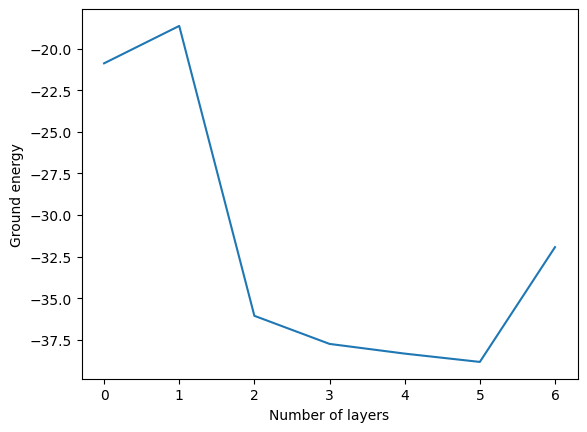

In [10]:
import matplotlib.pyplot as plt

hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)
mixer_hamiltonian = build_mixer_hamiltonian(nqubits)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

method = "Powell"
    
ground_energy = []
ground_state = []
for n_layers in range(1,8):
    initial_parameters =  0.01 *  (2 * np.random.random(n_layers * 2) - 1) * np.pi
    best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)
    #print("initial_parameters",initial_parameters)
    #print("best energy: ", best_energy)
    ground_energy.append(best_energy)
    
    qaoa.set_parameters(final_parameters)
    quantum_state = qaoa.execute(None)

    probabilities = (np.abs(quantum_state) ** 2)
    probabilities = zip(probabilities, [i for i in range(len(probabilities))])
    probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
    probabilities = [("{:.2f} %".format(round(p*100, 4)), "{0:0{bits}b}".format(s, bits=nqubits)) for p, s in probabilities]
    print(probabilities)
    qaoa_solution = probabilities[0][1]
    print("The best solution is:", qaoa_solution )
    print("-"*10)

plt.plot(ground_energy)
plt.xlabel('Number of layers')
plt.ylabel('Ground energy')

### Solve this hamiltonian using Quantum Adiabatic Evolution

        Setp 1. Define initial hamiltonian

In analogy to the mixer Hamiltonian, the initial Hamiltonian is defined as the sum of the Pauli X operators acting on each qubit,

$$\mathcal{H}_I = \sum_{i=1}^{6} \hat{\sigma}^x_i$$


In [11]:
def build_initial_hamiltonian(nqubits: int) -> SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the given graph.

    args:
        graph: graph
            A network graph

    returns:
        The mixer hamiltonian of the given graph

    '''
    # The mixing hamiltonian is defined by the sigma X operator
    # so the whole Hilbert Space of Fock states is explored
    mixing_hamiltonian = sum((X(i)) for i in range(nqubits))
    return SymbolicHamiltonian(mixing_hamiltonian)

    Step 2. Run the Adiabatic Evolution

The adiabatic evolution is a quantum algorithm that uses the adiabatic theorem to find the ground state of a Hamiltonian. The adiabatic evolution algorithm is defined by the following steps:

1. Prepare the initial state $|+\rangle^{\otimes n}$, where $n$ is the number of qubits.
2. Apply the adiabatic evolution circuit, which is composed of the initial and cost Hamiltonians.
3. Measure the qubits and evaluate the cost function.
4. Repeat steps 2-3 until the cost function converges to the optimal value.

In [12]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian


# build initial (H0) and target (H1) hamiltonians
H0 = build_initial_hamiltonian(nqubits=nqubits)
H1 = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.calculate_dense().matrix)
H0_dense = Hamiltonian(nqubits, H0.calculate_dense().matrix)

# Define the time steps
dt = 0.1

# Define the final evolution time
T = 20

# define the schedule. This is a function of time that defines the scheduling of the adiabatic evolution. 
# Can be either a function of time s(t) or a function with two arguments s(t, p) 
# where p corresponds to a vector of parameters to be optimized.
def s(t): return t

# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=T)

    Step 3. Display solution and compare it to the ground state you obtained in problem 1 and using QAOA

In [13]:
# obtain the state with the highest probability
solution_dec  = (np.abs(adiabatic_quantum_state) ** 2).argmax()
adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)


print("The optimal solution is: ", adiabatic_solution)

The optimal solution is:  011101


In [14]:
# Study for different T
T_values = np.linspace(10, 100, 10)
probabilities = []
for T in T_values:
    adiabatic_quantum_state = adiabatic_model.execute(final_time=T)
    solution_dec  = (np.abs(adiabatic_quantum_state) ** 2).argmax()
    probability = (np.abs(adiabatic_quantum_state[solution_dec]) ** 2)
    probabilities.append(probability)

# Probability of finding the optimal solution in function of the adiabatic evolution T
plt.plot(T_values, probabilities)
plt.xlabel("T (1/simulated chip frequency)")
plt.ylabel(r"$|\langle \psi_f | \psi_f \rangle|^2$")
plt.title("Probability of finding the optimal solution with T")
plt.show()


### What are the downsides to the method you used to reduce the number of qubits? 

Reducing the qubits needs one to find approximate a function thus we still have a penalty for small number of cases even when the constraints are satisfied. Moreover, since with the physical qubits we have at maximum 2 qubit controlled interactions, one should take care that the expansion is truncated at the 2nd order.

## Problem 3

### Given this new dataset generate a hamiltonian that only uses 3 qubits 

In [ ]:
import random 


random.seed(13)

# Define the number of items
n_items = 3

# Define ranges
max_duration_percentage = 0.7

# Fill the weights and values 
values   = [6, 2, 6]
duration = [3, 3, 6]

# Compute the maximum allowed weight
max_duration = int(max_duration_percentage * sum(duration))



# Print the instance
print("-" * 20)
print("Instance Details:")
print("-" * 20)
print(f"Duration                 : {duration}")
print(f"Values                   : {values}")
print(f"Total duration           : {sum(duration)}")
print(f"Maximum allowed duration : {max_duration}")

##### We use the same build_cost_hamiltonian function used in Problem 2, which in this instance uses 3 qubits.

In [ ]:
hamiltonian = build_cost_hamiltonian(values,duration,max_duration)

### Design a circuit layout that is suitable for this Hamiltonian

    Step 1. Create each element of the circuit

Your qubits will have a critical current of 230nA, shunting capacitance of 50fF, Z loop capacitance of 4.4fF, inductance of 480pH, x to z loop current ration of 0.4 and junction assymetry of 0.

The coupler's parameters are given

In [ ]:
import cas as cas

# coupler parameters
i_sigma = 565
c_sigma = 11
lc = 580
d = 0.0

# define couplers and qubits
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit2 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler12 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler02 = cas.Coupler(i_sigma, c_sigma, lc, d)
circuit_elements = [qubit0,coupler01,qubit1,coupler12,qubit2,coupler02]

    Step 2. Define the qubit-coupler interaction and create the circuit object

A good approximation is to consider only the first 5 energy levels of the qubit and the first 2 energy levels of the coupler

In [ ]:
m = 65; m_mat = np.zeros((6, 6)) # mutual inductance matrix (given)

m_mat[0, 1] = -m; m_mat[1, 2] = m
m_mat[2, 3] = -m; m_mat[3, 4] = m
m_mat[4, 5] = -m; m_mat[5, 0] = m

m_mat = -(m_mat + m_mat.T)

trunc_vec = np.array([6,3,6,3,6,3]) # truncation vector for the energies of each element
circuit = cas.AnnealingCircuit(circuit_elements, m_mat, trunc_vec)

### Design an annealing Ising schedule 

    Step 1. Define the starting (initial) and objective hamiltonian coefficients

##### We define the instance of initial Ising hamiltonian (h0), by considering the fact that the hamilitonian has non-zero transverse field coefficients $(h_{x}*\sigma_{x})$.
##### and has the form $ H = (h_{x}*\sigma_{x}) + (h_{y}*\sigma_{y}) + (h_{z}*\sigma_{z}) + (h_{I}*\sigma_{I})$.
##### From this initial hamiltonian, we desire to drive the system to the final hamiltonian we have built using 3 qubits for this case. Since we need the coefficients of pauli matrices, we simplify the hamiltonian to collect such terms and are used for Hamiltonian 'hf'. Thus we get non-zero longitudinal field coefficients $(h_{z}*\sigma_{z})$, terms proportional to the $\sigma_{I}$ and also the interacting terms  $(\sigma_{Z_{i}}*\sigma_{Z_{j}})$

In [ ]:
# initialization hamiltonian
h0 = {}; 
h0["x_0"] = 1*2*np.pi
h0["x_1"] = 0.8*2*np.pi
h0["x_2"] = 0.7*2*np.pi

h0["z_0"] = 1e-10
h0["z_1"] = 1e-10
h0["z_2"] = 1e-10

h0["I_0"] = 1e-10
h0["I_1"] = 1e-10
h0["I_2"] = 1e-10

h0["zz_01"] = 1e-10
h0["zz_12"] = 1e-10
h0["zz_02"] = 1e-10


# objective hamiltonian
#hf = ... # type: dict[str, np.ndarray]
hf = {};
hf["x_0"] = 1e-10
hf["x_1"] = 1e-10
hf["x_2"] = 1e-10

hf["z_0"] = 0.5*(values[0] - duration[0] + max_duration*duration[0] - duration[0]*sum(duration[i] for i in range(len(values))))
hf["z_1"] = 0.5*(values[1] - duration[1] + max_duration*duration[1] - duration[1]*sum(duration[i] for i in range(len(values))))
hf["z_2"] = 0.5*(values[2] - duration[2] + max_duration*duration[2] - duration[2]*sum(duration[i] for i in range(len(values))))

hf["I_0"] = 0.5*(-values[0] + duration[0] - max_duration + 2*max_duration**2 + 2 + 0.5*sum(duration[0]*duration[i] for i in range(len(values))) - max_duration*duration[0])
hf["I_1"] = 0.5*(-values[1] + duration[1] - max_duration + 2*max_duration**2 + 2 + 0.5*sum(duration[1]*duration[i] for i in range(len(values))) - max_duration*duration[1])
hf["I_2"] = 0.5*(-values[2] + duration[2] - max_duration + 2*max_duration**2 + 2 + 0.5*sum(duration[2]*duration[i] for i in range(len(values))) - max_duration*duration[2])

hf["zz_01"] = 0.25*(duration[0]*duration[1])
hf["zz_12"] = 0.25*(duration[1]*duration[2])
hf["zz_02"] = 0.25*(duration[0]*duration[2])

    Step 2. Create a method to get a an arbitrary schedule for the circuit designed above

##### The following function builds the schedule for the Ising coefficients from the initial h0 terms to the final desired hf terms by discretizing the coefficients. The discretization uses the lambda function passed as an argument to the get_schedule() function.

In [ ]:
def get_schedule(h0: dict[str, np.ndarray], hf: dict[str, np.ndarray], points: int, schedule: callable) -> dict[str, int | np.ndarray]:
    """Given the ising coefficients for the initial and final hamiltonian of the annealing scheduel,
    and given some time dependance of the schedule (eg. linear, exponential, etc), returns the ising
    coefficients for x and z at each time step.

    args:
        h0 (dict[str, np.ndarray]): ising coefficients of the starting hamiltonian h0
        hf (dict[str, np.ndarray]): ising coefficients of the target (final) hamiltonian hf
        points (int): number of points in the annealing schedule
        schedule (callable): time dependance of the schedule
    
    returns:
        dict[str, np.ndarray]: Dictionary of ising coefficients at each step of the schedule
    """

    ising_dict = {}; 
  
    ising_dict["points"] = points

    #linear_space = lambda start, stop, points: [start + i * (stop - start) / (points - 1) for i in range(points)]
    
    ising_dict["x_0"] = schedule(h0["x_0"], hf["x_0"], points)
    ising_dict["x_1"] = schedule(h0["x_1"], hf["x_1"], points)
    ising_dict["x_2"] = schedule(h0["x_2"], hf["x_2"], points)

    ising_dict["z_0"] = schedule(h0["z_0"], hf["z_0"], points)
    ising_dict["z_1"] = schedule(h0["z_1"], hf["z_1"], points)
    ising_dict["z_2"] = schedule(h0["z_2"], hf["z_2"], points)
    
    ising_dict["I_0"] = schedule(h0["I_0"], hf["I_0"], points)
    ising_dict["I_1"] = schedule(h0["I_1"], hf["I_1"], points)
    ising_dict["I_2"] = schedule(h0["I_2"], hf["I_2"], points)
    
    ising_dict["zz_0,1"] = schedule(h0["zz_01"], hf["zz_01"], points)
    ising_dict["zz_1,2"] = schedule(h0["zz_12"], hf["zz_12"], points)
    ising_dict["zz_0,2"] = schedule(h0["zz_02"], hf["zz_02"], points)
    
    return ising_dict



    Step 2. Get the ising coefficients for a linear and an exponential schedule for a resolution of 1ns

##### Using the above function we take an example of linear lambda function for discretization of pauli coefficients for further steps

In [ ]:
# linear schedule
linear_schedule = lambda start, stop, points: [start + i * (stop - start) / (points - 1) for i in range(points)] # feel free to use any callable (e.g. lambda function or method)
ising_linear = get_schedule(h0, hf, points=20, schedule=linear_schedule)
# exponential schedule
exponential_schedule  = lambda start, stop, points, base=10: [base ** x for x in [start + (stop - start) * i / (points - 1) for i in range(points)]]
ising_exp = get_schedule(h0, hf, points=20, schedule=exponential_schedule)

##### Now, we have the Ising schedule with desired type of discretization of pauli coefficients. We now define a function to get flux schedule of all the circuit elements using the desired optimizer

In [ ]:
def get_fluxes(ising_schedule: dict[str, int | np.ndarray], optimizer: str) ->  dict[str, int | np.ndarray]:
    """Get the flux schedule from a given ising schedule.

    Args:
        ising_schedule (dict[str, int  |  np.ndarray]): dictionary with the number of points in the schedule
            and the ising coefficients for each control of the circuit at each point of the schedule
        optimizer (str): name of the lmfit minimizer to use

    Returns:
        dict[str, int | np.ndarray]: dictionary containing the number of points in the schedule and the fluxes
            to be applied at each control of the circuit at each point of the schedule.
    """
    flux_dict = circuit.get_custom_fluxes_pwsw(ising_schedule, verbose=True, optimizer_method = optimizer)
    return flux_dict
    

In [ ]:
flux_dict_linear = get_fluxes(ising_linear,optimizer="leastsq")

In [ ]:
#flux_dict_exp= get_fluxes(ising_exp,optimizer="leastsq")

##### The above commented cell, calculates the flux schedule using the exponential discretization of the pauli coefficients in the Ising hamiltonian. The output gave a high relative error of single qubit residues. Thus, one of the conclusion that could be drawn is that, the above annealing from given h0 to hf using a exponential discretization of the pauli coefficients might be a bad choice.

### With the obtain fluxes calculate the energy spectrum of the circuit

    Step 1. Define a function to get the spectrum from the flux schedule using the code from CAS

In [ ]:
def get_schedule_spectrum(flux_dict: dict[str, int | np.ndarray], levels: int) -> np.ndarray:
    """Calculate the energy spectrum through the schedule. The more levels we try to calculate,
    the more computationally expensive this will be.

    Args:
        flux_dict (dict[str, int  |  np.ndarray]): dictionary containing the number of points in the schedule and the fluxes
            to be applied at each control of the circuit at each point of the schedule.
        levels (int): energy levels to compute

    Returns:
        np.ndarray: of size (schedule points, levels) with the energy gaps for each level (En - E0),
            where E0 is the ground state energy and En is the energy of level n.
    """
    return circuit.calculate_spectrum(flux_dict, levels=levels)

In [ ]:
spectrum_linear = get_schedule_spectrum(flux_dict_linear,levels=4)

In [ ]:
spectrum_linear

##### The above is the energy spectrum obtained for each timestep in the flux schedule. We opt to observe how the first 4 energy levels vary with time. One of the observation to note that is, at timestep=0, i.e., the first energy value set gives information of the ground state transverse field hamiltonian (h0) and at the final timestep, the circuit achieves to display the ground state of desired problem hamiltonian. One could also observe unidirectional change from h0 to hf. 

### Research questions

1. For the annealing schedules calculated, do any of the resulting spectral schedules fulfill the adiabatic theorem?
2. By this point you will have obtained two energies, one from the software challenge (QAOA) and one from the annealing schedule above. Argue their relation.
3.  If you have made it here, you have problaly seen the difficulties of solving small instances. Can you propose ways to scale these procedures to more qubits? Some techniques for finding the gap along the annealing process can be found in [1], [2], [3] and [4]. Can you implement a simulation from one of these papers? Research and propose better techniques to find the flux schedule for a given Ising schedule with a greater amount of qubits.  

In [ ]:
## Research question 1
E_01 = []
E_02 = []
E_03 = []
for i in range(20):
    E_01.append(np.abs(spectrum_linear[i][0] - spectrum_linear[i][1]))
    E_02.append(np.abs(spectrum_linear[i][0] - spectrum_linear[i][2]))
    E_03.append(np.abs(spectrum_linear[i][0] - spectrum_linear[i][3]))
min_gap_linear = min(E_01)
adiabatic_time = 1/(min_gap_linear)**2
print('Time constraint for the quantum annealing to be adaibatic is:',adiabatic_time)
plt.plot(np.linspace(0,20,20),E_01,np.linspace(0,20,20),E_02,np.linspace(0,20,20),E_03)
plt.xlabel('Unitless time')
plt.ylabel('|E0-E1| Gap for linear discretization')
plt.legend(['E_01','E_02','E_03'])

## Research problem 2
##### The energy spectrum obtained by quantum annealing above, is not the same as the eigenvalues of the Ising hamiltonian (hf). This is expected, because the energy spectrum above lies the eigenspace of the Persistent Current (Ip) basis while the Ising hamiltonian (hf) lies in the eigenspace built by Computational basis. Inorder to compare both the energy spectrums, one should do the mapping of the abive spectrum from Ip basis state to computational basis state. 

## Bibliography

[1] Adiabatic Spectroscopy and a Variational Quantum Adiabatic Algorithm: https://arxiv.org/abs/2103.01226

[2] Direct estimation of the energy gap between the ground state and excited state with quantum annealing: https://arxiv.org/abs/2007.10561

[3] Simulating quantum circuits by adiabatic computation: improved spectral gap bounds: https://arxiv.org/abs/1906.05233

[4] Spectroscopy on two coupled flux qubits: https://arxiv.org/abs/cond-mat/0308192

